# Safe Absorbing States

In [1]:
from NN import *
from LTL import *
from Utility_funcs import *

%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time


2023-05-24 15:10:47.395834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Omega-automaton states (including the trap state): 4


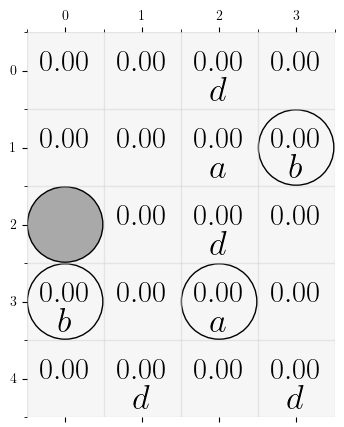

In [2]:
# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'T'],
['B',  'E',  'E',  'E'],
['T',  'E',  'T',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),       (),     ('d',),()],
[(),       (),     ('a',),('b',)],
[(),       (),     ('d',),()],
[('b',),   (),     ('a',),()],
[(),       ('d',), (),    ('d',)]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled_states(csrl, enc)

In [3]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)
predicates

{'a': [6, 14], 'b': [7, 12], 'd': [2, 10, 17, 19]}

In [4]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

2023-05-24 15:10:53.835592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 15:10:53.835933: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 4)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [5]:
model(ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [6]:
# model.load_weights(f'first_case_{p}')

In [7]:
# model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])

num_training_epochs =  5
num_test_epochs = 5
training = True
epochs = 20
# T = [10, 20, 30, 40, 50, 60, 80, 100, 200, 400]
T = [5, 6]
K = 1
search_depth = 400

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = max(10, int(200-1.5*i))
    # num_training_epochs = int(200 - 1.5*i)
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula, predicates, csrl.reward, ch_states,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, visited=set(), start=None, search_depth=search_depth,
                verbose=0, T=i, K=K)
        # print('N',N[(0,0,0,0)])
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula, predicates, csrl.reward, ch_states,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=100, visited=set(), start=None, search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)

    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

LTL [+++]  LDBA [ 0.0 ] path: [16, 16, 12, 12, 12]
LTL [+++]  LDBA [ 0.0 ] path: [16, 16, 16, 12, 12]
LTL [+++]  LDBA [ 0.0 ] path: [15, 15, 14, 14, 14]
LTL [+++]  LDBA [ 0.0 ] path: [16, 16, 16, 12, 12]
LTL [+++]  LDBA [ 0.0 ] path: [15, 15, 14, 14, 14]
Train wins: 5 / 5
LTL [---]  LDBA [ 0.0 ] path: [9, 9, 9, 9, 13]
LTL [+++]  LDBA [ 0.0 ] path: [5, 5, 6, 7, 7]
LTL [+++]  LDBA [ 0.0 ] path: [18, 18, 14, 14, 14]
LTL [+++]  LDBA [ 0.0 ] path: [15, 15, 14, 14, 14]
LTL [+++]  LDBA [ 0.0 ] path: [15, 15, 14, 14, 14]
Test wins: 4 / 5
LTL [+++]  LDBA [ 0.0 ] path: [13, 13, 14, 14, 14, 14]
LTL [+++]  LDBA [ 0.0 ] path: [4, 4, 0, 1, 5, 6]
LTL [+++]  LDBA [ 0.0 ] path: [9, 9, 5, 6, 7, 7]
LTL [+++]  LDBA [ 0.0 ] path: [16, 16, 12, 12, 12, 12]
LTL [+++]  LDBA [ 0.0 ] path: [13, 13, 12, 12, 12, 12]
Train wins: 5 / 5
LTL [+++]  LDBA [ 0.0 ] path: [16, 16, 12, 12, 12, 12]
LTL [+++]  LDBA [ 0.0 ] path: [9, 9, 9, 13, 14, 14]
LTL [---]  LDBA [ 0.0 ] path: [0, 0, 0, 0, 0, 4]
LTL [---]  LDBA [ 0.0 ] pat

In [8]:
# model.save_weights(filepath=f'first_case_{p}')

[80.0, 60.0]

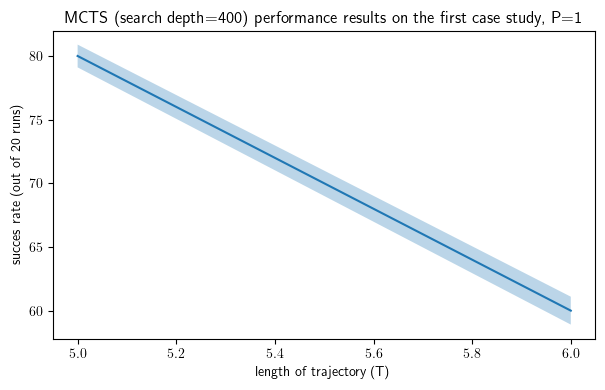

In [9]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 20 runs)")
plt.title("MCTS (search depth="+str(search_depth)+") performance results on the first case study, P="+str(p))
success_rates

In [10]:
Q=csrl.q_learning(T=100,K=100000)
np.save(f'Q1_{p}', Q)

In [11]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [12]:
rewards_mean = []
rewards_std = []
n_runs = 200

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=None, runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 200 simulations with 5 time-steps...
Test finished with:
	success rate: 77 / 200 = 0.385
Running 200 simulations with 6 time-steps...
Test finished with:
	success rate: 72 / 200 = 0.36


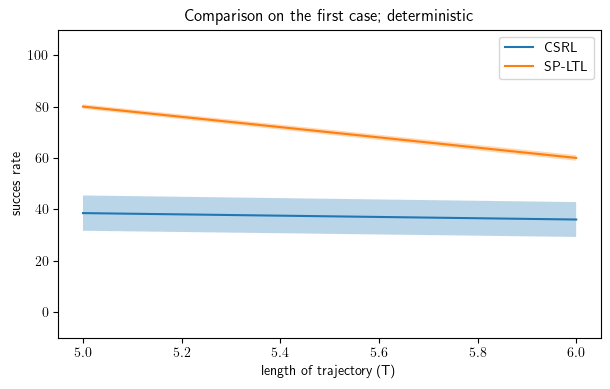

In [13]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
# plt.title("Comparison on the first case; stochastic")
plt.title("Comparison on the first case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C1_P{p}.pdf")

Text(0.5, 1.0, 'CSRL performance results on the first case study, P=1')

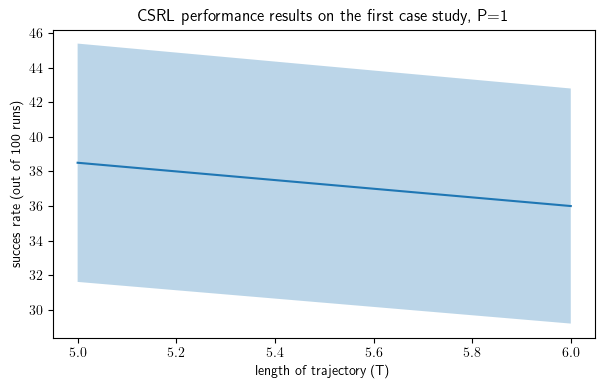

In [14]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate (out of 100 runs)")
plt.title("CSRL performance results on the first case study, P="+str(p))